In [1]:
import torchphysics as tp 
import pytorch_lightning as pl
import torch
X = tp.spaces.R2('x') # input is 2D
U = tp.spaces.R1('u') # output is 1D

Creates the plot for one single entry of the dataset with the Deep Ritz Method

In [2]:
square = tp.domains.Parallelogram(X, [0, 0], [1, 0], [0, 1])

In [3]:
# here set the structure of the newtwork:
model = tp.models.DeepRitzNet(input_space=X, output_space=U, depth=2, width=40)

In [4]:
# load external data
import torch 
import numpy as np
scaling = 100
xmin, xmax = 0, 1
ymin, ymax = 0, 1
Nx, Ny = 512, 512 
xx = np.linspace(xmin, xmax, Nx+1)
xx = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2).astype(np.float32)
xx = tp.spaces.Points(torch.tensor(xx), X)
f = scaling * torch.tensor(np.load('poisson_data_f_u.npy').astype(np.float32))
energy_sampler = tp.samplers.DataSampler(xx)

In [5]:
def energy_residual(u, x):
    return 1/2 * torch.sum(tp.utils.grad(u, x)**2, dim=1, keepdim=True) - f * u
 

energy_cond = tp.conditions.DeepRitzCondition(model, energy_sampler, energy_residual)

In [6]:
# boundary condition:
def bound_residual(u):
    return u**2

bound_sampler = tp.samplers.GridSampler(square.boundary, n_points=int(2052)).make_static()
bound_cond = tp.conditions.DeepRitzCondition(module=model, sampler=bound_sampler, 
                                             integrand_fn=bound_residual, weight=10000)

In [7]:
# here we start with Adam:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)

solver = tp.solver.Solver(train_conditions=[energy_cond, bound_cond], optimizer_setting=optim)

In [8]:
f = f.to('cuda')
trainer = pl.Trainer(gpus=1, # or None if CPU is used
                     max_steps=5000, 
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 6.7 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params
0.027     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Switch to LBFGS

In [9]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.2, 
                            optimizer_args={'max_iter': 2, 'history_size': 100})

solver = tp.solver.Solver(train_conditions=[bound_cond, energy_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=5000, 
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 6.7 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params
0.027     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

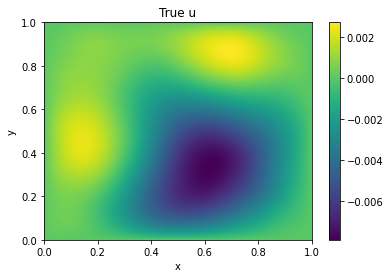

In [ ]:
import matplotlib.pyplot as plt
xmin, xmax = 0, 1
ymin, ymax = 0, 1
Nx, Ny = 512, 512 
xx = np.linspace(xmin, xmax, Nx+1)
xx = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2).astype(np.float32)
xx = tp.spaces.Points(torch.tensor(xx), X)
true_data = torch.tensor(np.load('poisson_data_f_u.npy').astype(np.float32))
plt.xlabel('x')#, fontsize=16, labelpad=15)
plt.ylabel('y')#, fontsize=16, labelpad=15)
plt.title(r"True u")
plt.imshow(true_data[:, 1].reshape(Nx+1, Nx+1), extent=[xmin, xmax, ymin, ymax], origin='lower', aspect = 'auto')#, vmin=0, vmax=1, )
plt.colorbar()

0.0067288875579833984


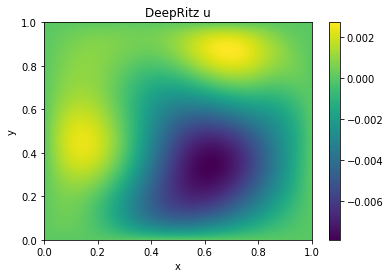

In [ ]:
import time
# pinn u:
xx = xx.to('cuda:0')
model.to('cuda:0')
start = time.time()
u_out = model(xx)
print(time.time() - start)
u_out = (u_out.as_tensor/ scaling).detach().cpu().reshape(1, Nx+1, Nx+1)
fig = plt.figure() #figsize=(10+4, 5)
plt.xlabel('x')#, fontsize=16, labelpad=15)
plt.ylabel('y')#, fontsize=16, labelpad=15)
plt.title(r"DeepRitz u")
plt.imshow(u_out[0], extent=[xmin, xmax, ymin, ymax], origin='lower', aspect = 'auto')#, vmin=0, vmax=1, )
plt.colorbar()
np.save("deepritz_u.npy", u_out[0])

tensor(0.0203)


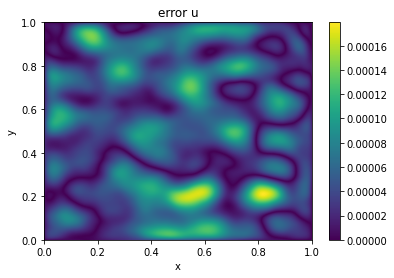

In [ ]:
fig = plt.figure() #figsize=(10+4, 5)
plt.xlabel('x')#, fontsize=16, labelpad=15)
plt.ylabel('y')#, fontsize=16, labelpad=15)
plt.title(r"error u")
diff = np.abs(u_out[0].numpy()-true_data[:, 1].numpy().reshape(Nx+1, Nx+1))
l2_rel = np.sqrt(np.sum(diff**2))/np.sqrt(sum(true_data[:, 1]**2))
plt.imshow(diff, 
           extent=[xmin, xmax, ymin, ymax], origin='lower', aspect = 'auto')#, vmin=0, vmax=1, )
plt.colorbar()
print(l2_rel)